In [18]:
from shutil import copyfile
import os
import numpy as np
from matplotlib import pyplot as plt

#print(os.getcwd())

Loading:  ./1-dataset/userdata-1-sine.csv


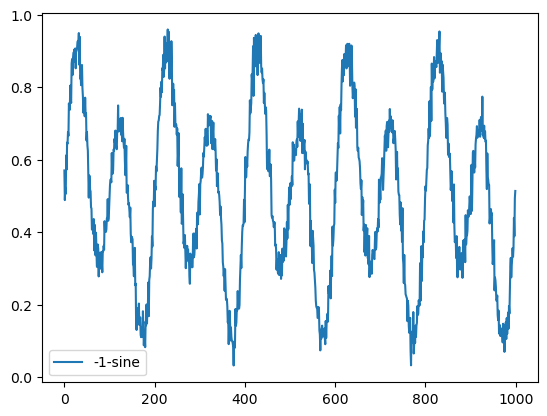

Loading:  ./1-dataset/userdata-2-triangle.csv


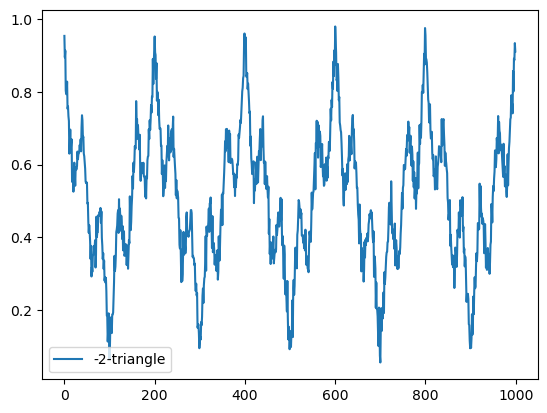

Loading:  ./1-dataset/userdata-3-sawtooth.csv


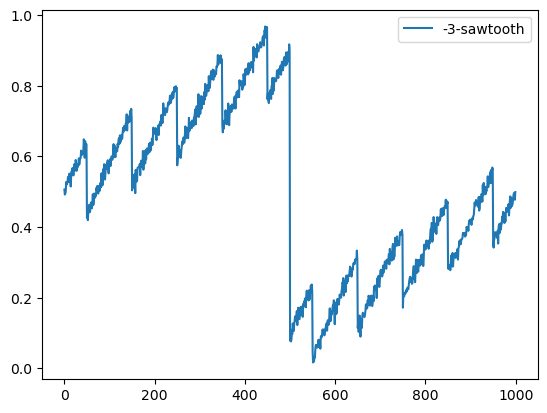

Loading:  ./1-dataset/userdata-4-random.csv


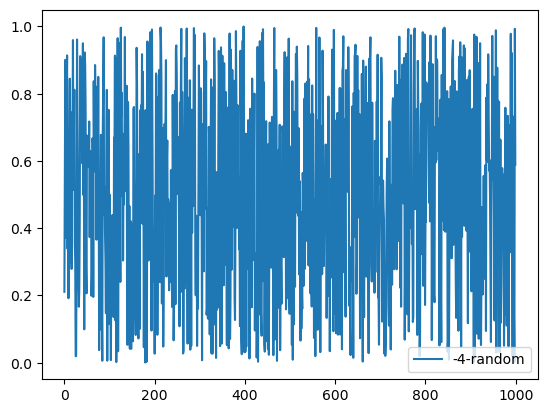

In [19]:
# Loading the dataset
my_delimeter = ","
PLOT_LIM = 1000  # how many data samples to display
datasize = -1  # make sure to use an any "NEGATIVE" value here

dir = "./1-dataset/"
users = ["-1-sine","-2-triangle","-3-sawtooth","-4-random"]

extension = ".csv"
datasets = []
for i in range(len(users)):
    
    src_file = dir + "userdata" + users[i] + extension
    print("Loading: ", src_file)

    dataset = np.loadtxt(src_file, delimiter=my_delimeter)
    datasets.append(dataset)

    #if i == 3: # TEST: plot the first loaded data
    plot_lim = np.min([PLOT_LIM, len(dataset)])
    #print(dataset)
    plt.plot(dataset[:plot_lim], label=users[i])
    plt.legend()
    plt.show()

    if datasize < 0:
        datasize = len(dataset)
    else:
        assert datasize == len(dataset)

#plt.legend()
#plt.show()

In [20]:
# debug
print("number of users datasets: ", len(datasets))
for i in range(len(users)):
    print("User-",i)
    print("\t dataset size: ", datasets[i].shape)
    print("\t", datasets[i][0:10])

number of users datasets:  4
User- 0
	 dataset size:  (50000,)
	 [0.5702 0.4884 0.5232 0.5057 0.6119 0.5728 0.6473 0.644  0.6766 0.6657]
User- 1
	 dataset size:  (50000,)
	 [0.9536 0.8946 0.9132 0.8032 0.7935 0.794  0.8279 0.7534 0.7598 0.7329]
User- 2
	 dataset size:  (50000,)
	 [0.5059 0.4916 0.4949 0.5007 0.5271 0.5203 0.5224 0.5291 0.5417 0.5322]
User- 3
	 dataset size:  (50000,)
	 [0.2108 0.5975 0.9007 0.5958 0.371  0.815  0.914  0.3387 0.5203 0.1917]


In [21]:
# formatting the dataset so that the formatted results can be used for deep learning training
def to_supervisedDataset(data, LookBackWindowSize, ForecastingHorizonSize):
    data_copy = np.array(data)
    #print("size: ", data.shape)
    assert len(data.shape) == 1  # make sure it's an 1D array
    
    n_input = LookBackWindowSize
    n_out = ForecastingHorizonSize

    X, y = [], []
    in_start = 0
    for _ in range(len(data_copy)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if( out_end < len(data_copy) ):
            x_input = data_copy[in_start:in_end]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data_copy[in_end:out_end])
        in_start += 1
    return np.array(X), np.array(y)


In [22]:
# split the dataset into train and test
def split_dataset(data, split_ratio):
    datalen = len(data)
    last_train_index = round(datalen * split_ratio)
    train = data[:last_train_index]
    test = data[last_train_index:]
    return train, test

In [23]:
# # check if GPU is available
# import tensorflow as tf 
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
# print("Available devices:", tf.config.list_physical_devices())

In [24]:
LookBackWindowSize = 128
ForecastingHorizonSize = 5

In [25]:
from tensorflow import keras
from keras import optimizers
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras import layers
"""
def build_model(param):
    model = Sequential()
    model.add(Conv1D(filters=param["filter"], 
                     kernel_size=param["kernel_size"], 
                     activation='relu',
                     input_shape=(param["n_lookback_timesteps"],param["n_features"])
                    )
             )
    model.add(MaxPooling1D(pool_size=param["pool_size"]))
    model.add(Flatten())
    model.add(Dense(param["dense_layer1_nodes"], activation=param["layer1_activation"]))
    model.add(Dense(param["dense_layer2_nodes"], activation=param["layer2_activation"]))
    model.add(Dense(param["n_outputs"], activation=param["final_activation"]))
    opt = keras.optimizers.Adam(learning_rate=param["lr"])
    model.compile(optimizer=opt,
                 loss='mse',
                 metrics=[tf.keras.metrics.Accuracy()])
    return model
"""
"""
from tensorflow import keras
from keras import optimizers
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

# LSTM model 
def build_model(param):
    model = Sequential()
    model.add(LSTM(param["lstm_nodes"], 
                   activation=param["lstm_activation"], 
                   input_shape=(param["n_lookback_timesteps"],param["n_features"])))
    model.add(Dense(param["dense_layer1_nodes"], activation=param["layer1_activation"]))
    model.add(Dense(param["dense_layer2_nodes"], activation=param["layer2_activation"]))
    model.add(Dense(param["n_outputs"], activation=param["final_activation"]))
    
    opt = keras.optimizers.Adam(learning_rate=param["lr"])
    model.compile(optimizer=opt,
                 loss='mse',
                 metrics=[tf.keras.metrics.Accuracy()])
    return model
"""
"""
We include residual connections, layer normalization, and dropout. The resulting layer can be stacked multiple times.
The projection layers are implemented through keras.layers.Conv1D.
"""
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

"""
The main part of our model is now complete. We can stack multiple of those transformer_encoder blocks 
and we can also proceed to add the final Multi-Layer Perceptron classification head.
Apart from a stack of Dense layers, we need to reduce the output tensor of the TransformerEncoder part 
of our model down to a vector of features for each data point in the current batch. 
A common way to achieve this is to use a pooling layer. For this example,
a GlobalAveragePooling1D layer is sufficient.
"""
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    ):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu",
                         kernel_initializer='random_normal',
                         bias_initializer='zeros')(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(ForecastingHorizonSize, activation="linear",
                           kernel_initializer='random_normal',
                           bias_initializer='zeros')(x)
    return keras.Model(inputs, outputs)    

In [26]:
train0, test0 = split_dataset(datasets[1], 0.9)
train0, val0 = split_dataset(train0, 0.9)
print(train0.shape)
print(val0.shape)
print(test0.shape)

Xtrain0, ytrain0 = to_supervisedDataset(train0, LookBackWindowSize, ForecastingHorizonSize)
Xval0, yval0 = to_supervisedDataset(val0, LookBackWindowSize, ForecastingHorizonSize)
Xtest0, ytest0 = to_supervisedDataset(test0, LookBackWindowSize, ForecastingHorizonSize)

print(Xtrain0.shape, ytrain0.shape)
print(Xval0.shape, yval0.shape)
print(Xtest0.shape, ytest0.shape)

(40500,)
(4500,)
(5000,)
(40367, 128, 1) (40367, 5)
(4367, 128, 1) (4367, 5)
(4867, 128, 1) (4867, 5)


In [27]:
from MyMetrics import mape, smape, rmse, mae, coeff_determination

In [28]:
with tf.device('/device:GPU:0'):
    model0 = build_model(
        input_shape = Xtrain0.shape[1:],
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128, 32],
        mlp_dropout=0.1, # 0.4
        dropout=0.1, # 0.25
    )

    model0.compile(
        loss = ['mse'],
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        metrics=[rmse, 'mae', smape, coeff_determination])
    model0.summary()

    callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

    training_history_model0 = \
    model0.fit(
        Xtrain0, ytrain0,
        validation_split=0.1,
        epochs=10,  # 어차피 early stopping이 적용될거라 epoch 커도 ok
        batch_size=128,
        callbacks=callbacks,
    )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 1)]             0         []                            
                                                                                                  
 layer_normalization_8 (Lay  (None, 128, 1)               2         ['input_2[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_4 (Mu  (None, 128, 1)               7169      ['layer_normalization_8[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_8[0][0]
                                                                    ']                      

In [29]:
# 학습 결과 관찰을 위한 데이터 추출
import matplotlib.pyplot as plt

def plotTrainingProgress(training_history, title, _ylim=None):
    history_dict = training_history.history
    losses = history_dict["loss"]
    val_losses = history_dict["val_loss"]

    # 학습 결과 시각화
    plt.plot(losses, label='loss')
    plt.plot(val_losses, label='val_loss')
    plt.legend()
    if _ylim is not None:
        plt.ylim(_ylim)
    plt.title(title)
    # plt.show()
    plt.savefig('Loss(triangle)(TF)[3].pdf')

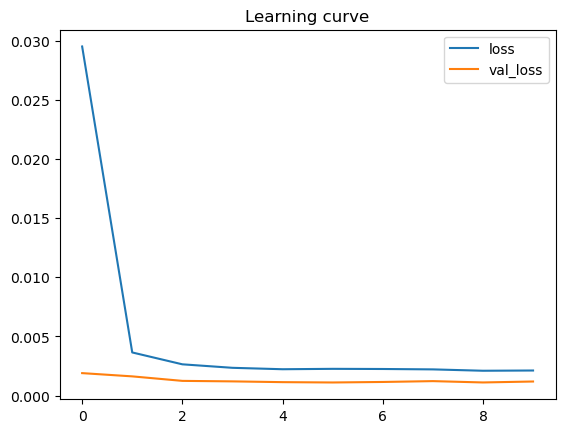

In [30]:
plotTrainingProgress(training_history=training_history_model0, 
                    title="Learning curve")

In [31]:
model0.evaluate(Xval0, yval0, verbose=1)

137/137 [==============================] - 36s 259ms/step - loss: 0.0012 - rmse: 0.0347 - mae: 0.0279 - smape: 3.4012 - coeff_determination: 0.8313


[0.001218734891153872,
 0.0346853993833065,
 0.027944112196564674,
 3.4012339115142822,
 0.8313480615615845]

In [32]:
actual0 = ytest0 # actual0 = yval0
pred0 = model0.predict(Xtest0)
assert len(actual0) == len(pred0)

print("RMSE : ", np.sqrt(mean_squared_error(actual0, pred0)))

153/153 [==============================] - 39s 249ms/step
RMSE :  0.03476462009668112


In [33]:
import numpy as np
import pandas as pd

results_df = pd.DataFrame({
    "Actual": ytest0.flatten(),
    "Predicted": pred0.flatten()
})
results_df.to_csv('results_TF_predictions(triangle)[3].csv', index=False)

history_df = pd.DataFrame(training_history_model0.history)
history_df.to_csv('results_TF_training_history(triangle)[3].csv', index=False)

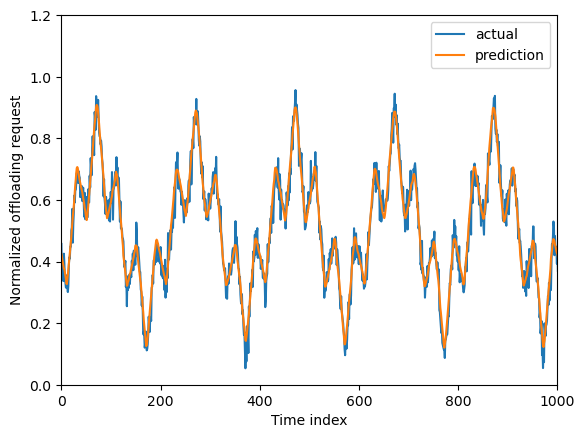

In [34]:
plot_pred = []
plot_actual = []
for i in range(min(len(actual0), len(pred0))):
    plot_pred.append(pred0[i][0]) 
    plot_actual.append(actual0[i][0])
plt.plot(plot_actual, label='actual')
plt.plot(plot_pred, label='prediction')
plt.legend()
plt.xlabel('Time index')
plt.ylabel('Normalized offloading request')
plt.xlim([0,1000])
plt.ylim([0,1.2])
#plt.show()
plt.savefig('Prediction(Triangle)(Transformer)[3]].pdf')